In [1]:
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk

abtem.config.set({"local_diagnostics.progress_bar": False});

# Multislice simulations

In our introduction to potentials, we described how to integrate the potential into a series of thin slices $V_n$ along the optical axis (see {eq}`eq:potentials:slice`). Given the wave function, moving fast along the optical axis and at the entrance of the $n$'th slice, $\phi_n(\vec{r})$, the wave function at exit of that slice may be written (see appendix)

$$
    \phi_{n + 1}(\vec{r}) = p(\vec{r}) * \left[t_n(\vec{r}) \phi_n(\vec{r}) \right]
$$ 

where 

$$
    p(\vec{r}) = \frac{1}{i \lambda \Delta z}\exp\left[\frac{i\pi}{\lambda \Delta z} r^2 \right]
$$

is the Fresnel free space operator for propagation by $\Delta z$ along the $z$-axis, $*$ is the convolution operator and 

$$
    t(\vec{r}) = \exp\left[i\sigma V_n(\vec{r})\right] 
$$

is the transmission function which applies a phase shift proportional to the magnitude of the potential, the proportionality constant, $\sigma$, is usually called the interaction constant. Using the Fourier convolution theorem we can write Eq. as

$$
    \phi_{n+1}(\vec{r}) = \mathcal{F}^{-1} \left\{P(\vec{k}) \ \mathcal{F}\left[t(\vec{r}) \phi_n(\vec{r})\right] \right\}  := \mathcal{M}_n \phi_n(\vec{r}) \quad ,
$$

where 

$$
    P(\vec{k}) = \exp(-i \pi \lambda k^2 \Delta z)
$$

is the Fresnel free space propagator in Fourier space and $\mathcal{F}$ and $\mathcal{F}^{-1}$ is the Fourier transform and its inverse.


For brevity we defined the multislice operator, $\mathcal{M}_n$, acting on a wave function to step it forward through the $n$'th slice. Thus given an initial wave function $\phi_0$, we can obtain the exit wave function for a potential with slice indices $n=0,1,\ldots N$ by sequentially applying these operators

$$
    \phi_{exit}(\vec{r}) := \phi_{N}(\vec{r}) = \mathcal{M}_N \mathcal{M}_{N-1} \ldots \mathcal{M}_{0} \phi_0(\vec{r}) \quad .
$$

## Multislice simulations with plane waves

Below we create a `Potential` and a `PlaneWave`:

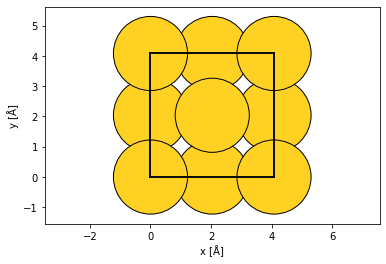

In [2]:
atoms = bulk("Au", cubic=True) * (1, 1, 10)

abtem.show_atoms(atoms, show_periodic=True, scale=0.9);

In [3]:
potential = abtem.Potential(atoms, slice_thickness=1, sampling=0.05)

plane_wave = abtem.PlaneWave(energy=300e3)

We create a task graph for running the multislice algorithm by calling `multislice` producing an exit wave function.

In [5]:
exit_wave = plane_wave.multislice(potential)

To execute the task graph, we call `compute`.

In [6]:
exit_wave.compute();

```{note}
Notice that we did not provide the sampling or extent of the wave function above, instead the wave function adopted the grid of the potential. A `GridUndefinedError` will be thrown if the grid is not defined for both the wave function and potential.
```

We can show the intensity of the resulting exit wave function. 

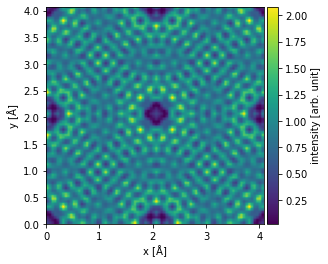

In [7]:
exit_wave.intensity().show(cbar=True);

### Electron diffraction patterns

In [8]:
exit_wave.diffraction_patterns(block_direct=True, max_angle=35)

-------------------------------------------------------------------

type              label       coordinates
----------------  ----------  --------------------
FourierSpaceAxis  kx [1 / Å]  -1.96 -1.72 ... 1.96
FourierSpaceAxis  ky [1 / Å]  -1.96 -1.72 ... 1.96

        bytes     shape     count     type
------  --------  --------  --------  -------------
array   1.13 kiB  (17, 17)  -         float32
chunks  -         -         - chunks  numpy.ndarray

We set `block_direct=True` to block the direct beam. The direct beam typically has a much higher intensity than the scattered beams and thus it may not be possible to show it on the same scale. 

The diffraction spots looks like squares. This is because the incoming beam is a periodic (and effectively infinite) plane wave, hence the diffraction spots are points with no size. However, we are discretizing the wave function on a square grid (i.e. pixels), hence the spots can only be as small as single pixels. 



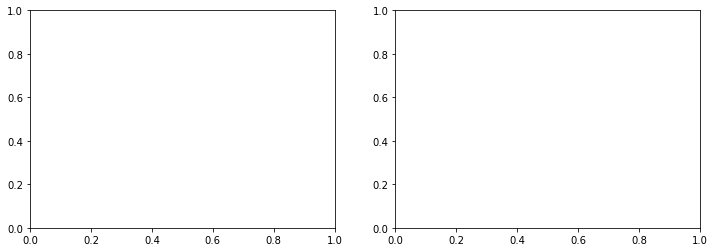

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# .show(
#    ax=ax2, units="mrad", cbar=True
# );

## Writing wave functions

As one should expect the wave functions can be written to disk (and read again).

In [10]:
exit_wave.to_zarr("./data/exit_wave.zarr", overwrite=True)

imported_wave = abtem.from_zarr("./data/exit_wave.zarr")

assert imported_wave == exit_wave

```{note}

```

## Thickness series

*abTEM* allows us to obtain the wave function at the intermediate steps of the multislice algorithm, thus we can see how the wave function evolves as it passes through the potential. To create such a *thickness series* we set the `exit_planes` keyword, this may be given as a tuple of the slice indices ($n$) to return, or just a single integer to indicate the step between slice indices. 

Below we create a `Potential` as above with `exit_planes=12`, resulting in the *ensemble* of wave functions $\phi_n(\vec{r})$ with $n=0,12,24,\ldots$.

In [11]:
potential_series = abtem.Potential(
    atoms, slice_thickness=1, sampling=0.05, exit_planes=12
)

exit_wave_series = plane_wave.multislice(potential_series)

exit_wave_series

-------------------------------------------------

type           label    coordinates
-------------  -------  --------------------
ThicknessAxis  z [Å]    0.00 11.94 ... 40.80
RealSpaceAxis  x [Å]    0.00 0.05 ... 4.03
RealSpaceAxis  y [Å]    0.00 0.05 ... 4.03

        bytes       shape        count     type
------  ----------  -----------  --------  -------------
array   262.66 kiB  (5, 82, 82)  4 tasks   complex64
chunks  262.66 kiB  (5, 82, 82)  1 chunks  numpy.ndarray

We show the wave function intensity as an exploded plot.

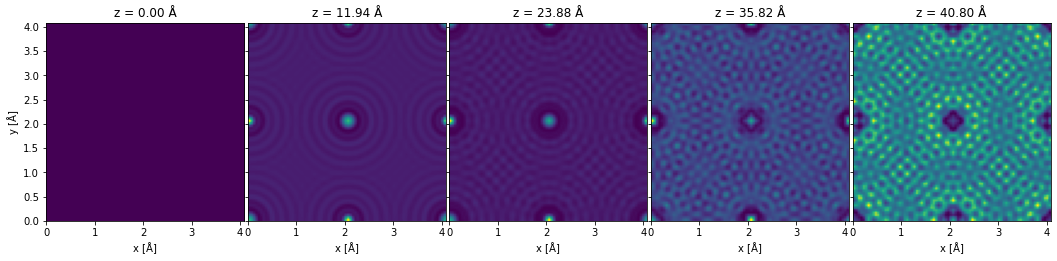

In [12]:
exit_wave_series.show(
    explode=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

## Multislice simulation with a probe
We create our initial wave function as a convergent electron beam with an energy of $200 \ \mathrm{keV}$ and a convergence semiangle of $30 \ \mathrm{mrad}$.

In [13]:
probe = abtem.Probe(
    energy=200e3,
    semiangle_cutoff=20,
    defocus=80,
)

There are two additional considerations to take into when performing multislice simulations with probes: self-interaction errors and probe placement. 

### Self-interaction
Self-interaction errors happen when the probe overlaps with its periodic images. We see this happening below, the signs are that the probe does not have a circular symmetry, even though there are no non-symmetric aberrations. 

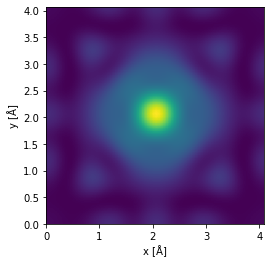

In [14]:
probe.grid.match(potential)

probe.build().show();

We get rid of self-interaction by increasing the extent of the potential until the probe intensity is sufficiently small at the boundary. Note that the potential should be large enough so there is no periodic overlap through all the slices of the multislice algorithm.

The potential may be extended by modifying the atoms, however, for crystals we can also use the `CrystalPotential`. Here we repeat the potential used above by $2$ in and $x$ and $y$.

In [15]:
tiled_potential = abtem.CrystalPotential(potential, (2, 2, 1), exit_planes=12)

We run the multislice algorithm below 

We plot the resulting thickness

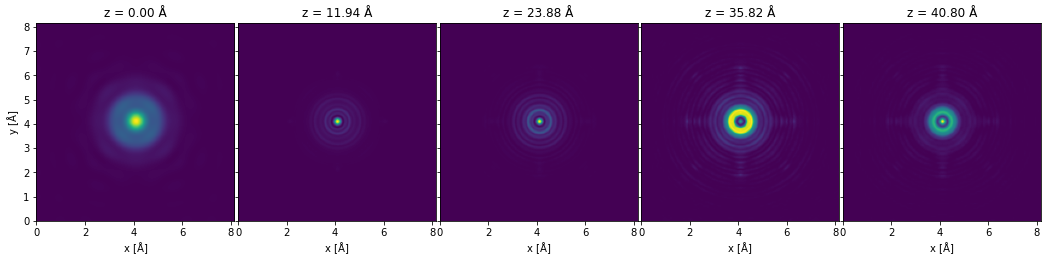

In [16]:
exit_wave_probe = probe.multislice(potential=tiled_potential)

exit_wave_probe.show(
    explode=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

### Probe position

Above, the probe was placed (by default) at the center of the potential, later we will learn scan the probe for STEM simulations. Here, we manually select a few positions.

We create an array of $5$ probe positions across the center of the potential.

In [95]:
center = tiled_potential.extent[0] / 2, tiled_potential.extent[1] / 2

positions = center + np.array([np.linspace(-1.04, 1.04, 5), np.zeros(5)]).T

positions

array([[3.04, 4.08],
       [3.56, 4.08],
       [4.08, 4.08],
       [4.6 , 4.08],
       [5.12, 4.08]])

Running the multislice algorithm we obtain an ensemble of $5$ wave functions, one for each of the positions.

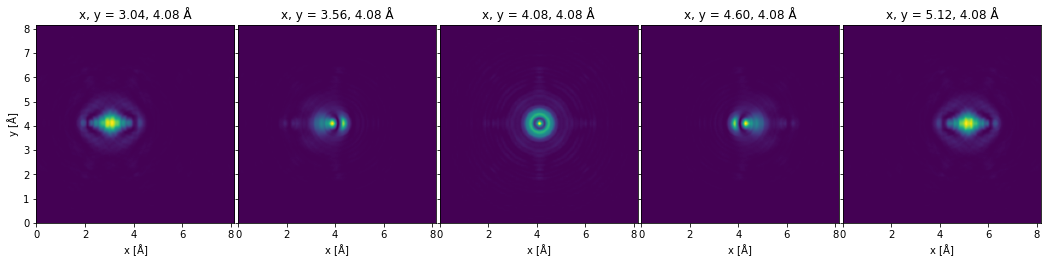

In [96]:
exit_wave_probe_positioned = probe.multislice(
    scan=positions, potential=abtem.CrystalPotential(potential, (2, 2, 1))
)

exit_wave_probe_positioned.show(
    explode=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

### Convergent beam electron diffraction

The diffraction pattern can be calculated in the same manner as the ED pattern.

In [94]:
exit_wave_probe_positioned[:, 2].diffraction_patterns(max_angle=40).show(
    explode=True,
    figsize=(16, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

RuntimeError: base axes cannot be indexed

As we can see above the Fourier space pixel size is rather large. We improve Fourier space sampling by tiling 

In [21]:
cbed_diffraction_pattern[:, 2] = probe_exit_wave.diffraction_patterns(max_angle=40)

ax, im = cbed_diffraction_pattern.show(
    units="mrad",
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
    image_grid_kwargs={"axes_pad": 0.05},
)

NameError: name 'probe_exit_wave' is not defined

In [ ]:
probe_exit_wave.diffraction_patterns

In [ ]:
cbed_diffraction_pattern = probe_exit_wave.diffraction_patterns(max_angle=200)

ax, im = cbed_diffraction_pattern.show(
    units="mrad",
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
    power=0.2,
    image_grid_kwargs={"axes_pad": 0.05},
)

## Small-angle beam tilt

Small amounts of beam tilt (or equivalently sample tilt) may be included by a small modification to the propagator function

$$
    P(\vec{k}) = \exp\left[-i \pi \lambda k^2 \Delta z + 2 \pi i \Delta z (k_x \tan\theta_x + k_y \tan\theta_y)\right]
$$

where $\theta_x$, $\theta_y$ is the beam tilt in the $x$, $y$ directions. This is equivalent to shifting the wave function between slices and is only valid for small tilts of no more that about $1 \ \mathrm{deg}$.

Beam tilt may be included using the tilt keyword, below we  

In [97]:
tilt_x = abtem.distributions.uniform(0, 20, 5)

probe_tilt = abtem.Probe(
    energy=200e3, semiangle_cutoff=20, defocus=80, tilt=(tilt_x, 0.0)
)
probe_tilt.grid.match(tiled_potential)

In [98]:
exit_wave_tilt = probe_tilt.multislice(
    potential=abtem.CrystalPotential(potential, (2, 2, 1))
).compute()

# probe_tilt.build().compute()

In [104]:
exit_wave_tilt[-1].base_tilt

(0.0, 0.0)

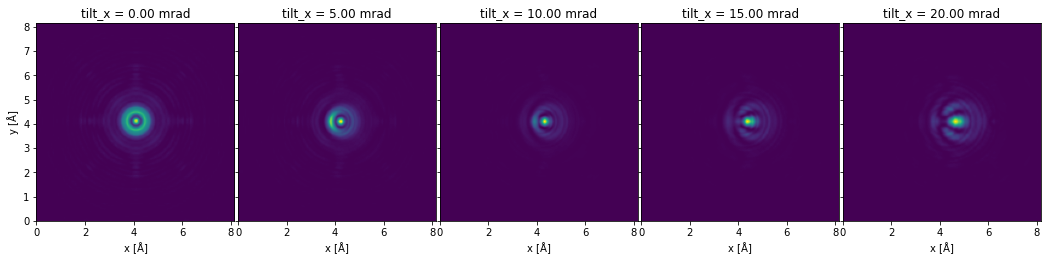

In [100]:
exit_wave_tilt.show(
    explode=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

```{note}
Beam tilt also has a strong interaction with with the aberrations of the electron optics, see our introduction to the contrast transfer function for details.
```